# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [2]:
DATA_PATH = '../data'
MODEL_PATH = '../src/models'

### Util Functions

In [3]:
def train_valid_test_split(X, y, TEST_SIZE=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size = TEST_SIZE, 
        random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    roc_auc = roc_auc_score(actual, pred)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        print(f"ROC-AUC Score:\t{roc_auc:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR, roc_auc]

# Prototype 2: Basic Sequential NN

### Get Data

In [11]:
# Get SNN Data
feature_matrix = pd.read_csv(f'{DATA_PATH}/processed/SNN_feature_matrix.csv')
feature_matrix.head()

,FPF_TARGET,LOAN_mean,meanEXTERNAL_TRANSFER,medianMORTGAGE,medianINSURANCE,meanLOAN,minESSENTIAL_SERVICES,ATM_CASH_mean,medianFOOD_AND_BEVERAGES,GROCERIES_count,...,medianOVERDRAFT,RENT_prop,medianUNCATEGORIZED,meanCREDIT_CARD_PAYMENT,medianGIFTS_DONATIONS,minBNPL,maxbalance,TAX_prop,minENTERTAINMENT,meanAUTOMOTIVE
0,0.0,345.082200,79.478235,1372.41,87.50,358.890312,5.00,216.942244,10.00,10.730769,...,0.00,0.0,37.000,311.720326,5.98,0.0,253.01,0.000000,1.85,28.204112
1,0.0,866.531397,826.376709,0.00,418.07,928.079878,24.00,796.689817,28.60,20.076923,...,0.00,0.0,200.000,988.767167,50.00,0.0,31564.64,0.001093,7.49,52.274545
2,0.0,1802.527857,464.490968,0.00,53.77,1713.210000,5.00,370.169317,25.00,7.769231,...,0.00,0.0,19.765,151.407725,0.00,0.0,31229.66,0.000000,1.99,36.806136
3,0.0,933.743056,108.286707,0.00,155.61,874.035714,1.00,201.847222,28.98,3.833333,...,0.00,0.0,21.720,224.630698,40.00,0.0,6425.61,0.000000,11.99,37.967524
4,0.0,2457.143333,192.407646,0.00,896.42,2318.397000,10.66,74.051970,21.00,3.800000,...,36.12,0.0,20.000,172.375000,20.80,0.0,1009.99,0.000000,20.94,74.697391


In [12]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(
    X, 
    y, 
    TEST_SIZE = TEST_SIZE, 
    random_state = 42
)

### Define Model

In [13]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)

In [14]:
# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [16]:
def train_SNN(
        model, 
        loss_fn, 
        optimizer, 
        X_train_tensor, 
        y_train_tensor, 
        X_valid_tensor, 
        y_valid_tensor, 
        n_epochs=200,
        batch_size=64, 
        display=True):
    
    batch_start = torch.arange(0, X_train_tensor.shape[0], batch_size)
    train_history = []
    valid_history = []
    best_valid = np.inf
    
    # training loop
    bar = tqdm(range(n_epochs))
    for epoch in bar:
        model.train()
        bar.set_description(f"Epoch {epoch+1}")
        for start in batch_start:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred_train = model(X_train_tensor)
        y_pred_valid = model(X_valid_tensor)
        train_loss = float(loss_fn(y_pred_train, y_train_tensor))
        valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
        
        bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
        train_history.append(train_loss)
        valid_history.append(valid_loss)

        if (valid_loss < best_valid):
            torch.save(model.state_dict(), f'{MODEL_PATH}/nn_base_params.pt')

    if display:
        print(f"Best Epoch: {np.argmin(valid_history)}")
        print(f"Loss: {np.min(valid_history)}")
    model.load_state_dict(torch.load(f'{MODEL_PATH}/nn_base_params.pt'))
    return model, train_history, valid_history

In [17]:
# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 64  # size of each batch

# train model
model, train_history, valid_history = train_SNN(
    model, 
    loss_fn,
    optimizer,
    X_train_tensor, 
    y_train_tensor, 
    X_valid_tensor, 
    y_valid_tensor, 
    n_epochs = n_epochs,
    batch_size = batch_size,
    display=False
)

Epoch 200: 100%|██████████| 200/200 [00:12<00:00, 16.25it/s, Train_MSE=0.373, Valid_MSE=0.48] 


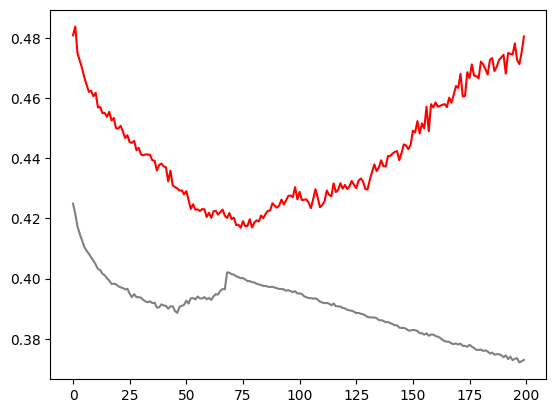

In [18]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [19]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return (1 / (1 + np.e ** (-1 * arr)))

def find_best_prob(pred_prob, actual, display=True):
    best_prob = 0
    best_score = -np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        if display:
            print(
                f"i\t" + 
                f"roc_auc\t" + 
                f"acc\t" + 
                f"conf_matrix" + 
                "\n==================================================="
            )
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            score = metrics[8]

            if display:
                print(
                    f"{i:.2f}\t" + 
                    f"{score:0.3f}\t" + 
                    f"{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t" + 
                    f"{metrics[:4]}"
                )

            if (score > best_score):
                best_score = score
                best_prob = i
    if display: print(f"Best Threshold: {best_prob:0.2f}")
    return best_prob

In [20]:
valid_pred_prob = model(X_valid_tensor).detach().numpy()[:,0]
# valid_pred_prob = standardize_output(valid_pred_prob)
threshold = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > threshold

test_pred_prob = model(X_test_tensor).detach().numpy()[:,0]
# test_pred_prob = standardize_output(test_pred_prob)
test_pred = test_pred_prob > threshold

i	roc_auc	acc	conf_matrix
0.00	0.551	29.35	[38, 337, 0, 102]
0.05	0.756	64.99	[214, 161, 6, 96]
0.10	0.773	70.44	[245, 130, 11, 91]
0.15	0.784	74.42	[268, 107, 15, 87]
0.20	0.769	76.10	[283, 92, 22, 80]
0.25	0.749	77.36	[297, 78, 30, 72]
0.30	0.716	77.78	[309, 66, 40, 62]
0.35	0.687	78.83	[324, 51, 50, 52]
0.40	0.649	79.04	[336, 39, 61, 41]
0.45	0.620	79.45	[347, 28, 70, 32]
0.50	0.574	79.66	[361, 14, 83, 19]
0.55	0.500	78.62	[375, 0, 102, 0]
0.60	0.500	78.62	[375, 0, 102, 0]
0.65	0.500	78.62	[375, 0, 102, 0]
0.70	0.500	78.62	[375, 0, 102, 0]
0.75	0.500	78.62	[375, 0, 102, 0]
0.80	0.500	78.62	[375, 0, 102, 0]
0.85	0.500	78.62	[375, 0, 102, 0]
0.90	0.500	78.62	[375, 0, 102, 0]
0.95	0.500	78.62	[375, 0, 102, 0]
Best Threshold: 0.15


In [21]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7442
tn:  268,  fp:  107,  fn:  15, tp:  87
Precision:			0.44845
Recall:				0.85294
TPR:				0.85294
FPR:				0.71467
Positive likelihood ratio:	1.19348
Negative likelihood ratio:	0.83789
ROC-AUC Score:	0.78380
Testing:
Accuracy: 0.7181
tn:  342,  fp:  156,  fn:  12, tp:  86
Precision:			0.35537
Recall:				0.87755
TPR:				0.87755
FPR:				0.68675
Positive likelihood ratio:	1.27784
Negative likelihood ratio:	0.78257
ROC-AUC Score:	0.78215


# Visualizing Feature Impact

In [22]:
from scipy import stats

In [23]:
X_valid_df = pd.DataFrame(
    # np.array([stats.zscore(col) for col in X_valid])
    np.array([stats.zscore(col) for col in X_valid.T]).T
    # X_valid
)
X_valid_df.rename(
    dict(zip(np.arange(X.shape[1]), feature_matrix.iloc[:,1:].columns)),
    axis=1,
    inplace=True
)
X_valid_df['pred_y'] = valid_pred.astype(float)
X_valid_df['y'] = y_valid
X_valid_df.head()

,LOAN_mean,meanEXTERNAL_TRANSFER,medianMORTGAGE,medianINSURANCE,meanLOAN,minESSENTIAL_SERVICES,ATM_CASH_mean,medianFOOD_AND_BEVERAGES,GROCERIES_count,HOME_IMPROVEMENT_mean,...,medianUNCATEGORIZED,meanCREDIT_CARD_PAYMENT,medianGIFTS_DONATIONS,minBNPL,maxbalance,TAX_prop,minENTERTAINMENT,meanAUTOMOTIVE,pred_y,y
0,-0.148498,0.077739,-0.155053,-0.670772,-0.144597,0.427379,-0.180935,-0.102182,0.439538,-0.378917,...,-0.275727,1.325403,-0.256987,-0.218458,2.130508,-0.153520,-0.137667,-0.058862,0.0,0.0
1,-0.175404,-0.284006,-0.155053,0.127967,-0.166879,-0.234655,-0.337227,-0.080831,-0.130887,-0.378917,...,-0.190648,-0.248437,-0.266380,-0.218458,-0.287457,-0.153520,-0.143257,-0.080193,1.0,0.0
2,-0.184829,-0.173473,-0.155053,-0.670772,-0.184910,-0.315786,0.429210,-0.074015,-0.709686,-0.378917,...,-0.277783,-0.249508,-0.266380,-0.218458,-0.328896,-0.153520,0.287451,-0.060521,1.0,0.0
3,-0.210394,-0.248651,-0.155053,-0.659127,-0.208203,-0.359348,-0.272268,-0.123307,0.967051,-0.378917,...,-0.251369,-0.378945,-0.266380,4.130425,-0.317280,-0.153520,0.176180,-0.075335,1.0,0.0
4,0.171698,-0.323962,-0.155053,3.862338,0.108478,-0.309546,-0.318931,-0.120464,0.568518,-0.074519,...,-0.216116,-0.222795,0.038875,-0.218458,-0.265151,0.776192,-0.194633,-0.045769,0.0,0.0


In [24]:
valid_pred_0 = X_valid_df[X_valid_df['pred_y'] == 0].iloc(axis=1)[:-2]
valid_pred_1 = X_valid_df[X_valid_df['pred_y'] == 1].iloc(axis=1)[:-2]

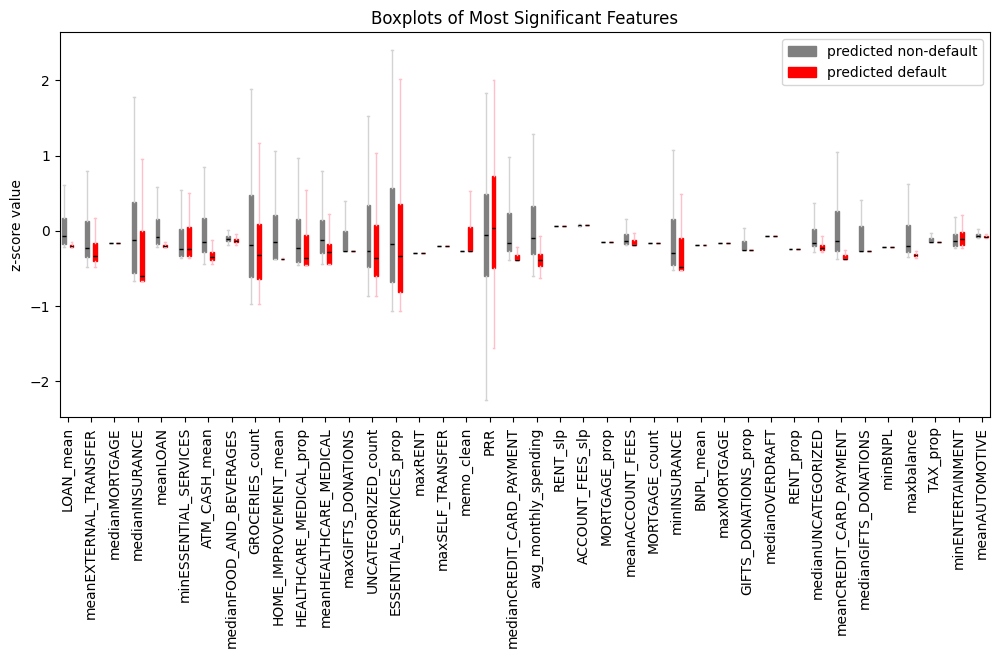

In [25]:
nfeatures = valid_pred_0.shape[1]
step_size = 3

fig, ax = plt.subplots(figsize=(12, 5))

bp0 = ax.boxplot(
    valid_pred_0, 
    positions=np.arange(0,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='gray', color='gray'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='lightgray'),
    capprops=dict(color='lightgray'),
    showfliers=False
)

bp1 = ax.boxplot(
    valid_pred_1, 
    positions=np.arange(1,nfeatures*step_size,step_size),
    patch_artist=True, 
    boxprops=dict(facecolor='red', color='red'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='pink'),
    capprops=dict(color='pink'),
    showfliers=False
)

ax.set_title("Boxplots of Most Significant Features")
ax.legend([bp0["boxes"][0], bp1["boxes"][0]], ['predicted non-default', 'predicted default'], loc='upper right')
ax.set_ylabel('z-score value')
# ax.set_ylim(-0.4, 0.3)
ax.set_xticks(np.arange(0.5, nfeatures*step_size,step_size))
ax.set_xticklabels(valid_pred_0.columns, rotation=90);